In [1]:
import sys
sys.path.append('../')
from initial_classif.classifier.classifier import binary_classification
import pickle
import glob
from config import configuration
import healpy
config = configuration()
config.request_password()

/home/jls/.local/lib/python3.5/site-packages/xgboost/__init__.py:29: FutureWarning: Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.
  FutureWarning)


 ·············


In [184]:
import sqlutilpy
gg = pd.DataFrame(sqlutilpy.get('''
select healpix_ang2ipix_nest(2048,l,b), count(*) 
from leigh_smith.virac2 
where 
ks_ivw_mean_mag<17 and ks_ivw_mean_mag>11.5
and ks_n_detections>20
and duplicate=0
and astfit_params=5
group by healpix_ang2ipix_nest(2048,l,b)''',
                **config.wsdb_kwargs)) 

In [185]:
map_=np.zeros(healpy.nside2npix(2048))*healpy.UNSEEN
map_[gg['healpix_ang2ipix_nest']]=gg['count']

In [77]:
with open('/local/scratch_2/jls/virac_classifier/variable/edr3_EAEB/variable_features_total.pkl', 'rb') as f:
    total_features = pickle.load(f)

In [264]:
from matplotlib.colors import PowerNorm

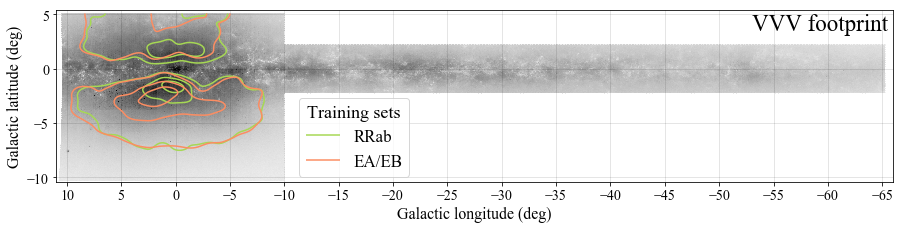

In [305]:

ff=plt.figure(figsize=[15.,4.])
from astropy_healpix import lonlat_to_healpix
def query(x,y):
    match_ipix=lonlat_to_healpix(x*u.deg, y*u.deg, 2048, order='nested')
    i = np.searchsorted(gg['healpix_ang2ipix_nest'].values, match_ipix, side='right') - 1
    cc = gg['count'].values[i]
    cc[gg['healpix_ang2ipix_nest'].values[i]!=match_ipix]=0.
    return cc
ssize=1549 #3049
extent=[[-70.,12.],[-11.,6.]]
XGRID = np.linspace(extent[0][0],extent[0][1],ssize)
XGRID=.5*(XGRID[1:]+XGRID[:-1])
YGRID = np.linspace(extent[1][0],extent[1][1],ssize)
YGRID=.5*(YGRID[1:]+YGRID[:-1])
XGRID,YGRID = np.meshgrid(XGRID,YGRID,indexing='ij')
XGRID=XGRID.flatten()
YGRID=YGRID.flatten()

exM = query(XGRID,YGRID)
I=plt.imshow(np.reshape(exM,(ssize-1,ssize-1)).T,
           origin='lower',cmap=plt.cm.Greys,#cmap=plt.cm.magma_r,
           extent=sum(extent,[]),norm=PowerNorm(.5),vmax=4000)

wrap = lambda x: x-(x>180.)*360.
# nn= plt.hist2d(wrap(total_features['l']),total_features['b'],bins=350,norm=LogNorm())

colors = [sns.color_palette('Set2')[4],sns.color_palette('Set2')[1]]
for ii,lbl in enumerate(['RRab','EA/EB']):
    fltr = (total_features['var_class']==lbl)
    nn, x, y = np.histogram2d(wrap(total_features['l'])[fltr],total_features['b'][fltr],bins=200)
    import seaborn as sns
    from scipy.ndimage import gaussian_filter

    nn=gaussian_filter(nn.T,5.)
    c = plt.contour(.5*(x[1:]+x[:-1]),.5*(y[1:]+y[:-1]),nn,
                         origin='lower',
                         colors=[colors[ii]],
                         label=lbl,
                         contours=10,
                           levels=[np.max(nn)/10.,np.max(nn)/2.,np.max(nn)/1.2],
                   linewidths=1.5)
    c.collections[0].set_label(lbl)
#     plt.plot(wrap(total_features['l'])[fltr],total_features['b'][fltr],'.',ms=0.1)
plt.gca().invert_xaxis()
plt.gca().set_aspect('equal')
plt.xlim(11.,-66)
plt.ylim(-10.4,5.4)
lg=plt.legend(loc='lower left',title='Training sets',fontsize=17,
             bbox_to_anchor=(0.28,-0.02))
title = lg.get_title()
title.set_fontsize(18)
plt.xlabel('Galactic longitude (deg)')
plt.ylabel('Galactic latitude (deg)')
plt.annotate('VVV footprint',xy=(-53,3.5),fontsize=23)
plt.grid(zorder=0,color='k',lw=0.5,alpha=0.2)
plt.xticks(-np.arange(-10,66,5));
plt.gca().set_aspect('equal')
plt.savefig('footprint.pdf',bbox_inches='tight')

In [ ]:
var.f